# Exercise 4
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In this exercise, you will accomplish the following:
1. Train a Localization as Regression network using a pre-trained model.
2. Build and train a recurrent neural network that will generate text.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.patches as patches
import torchvision.models as models
from PIL import Image
import collections
import time
import copy
import sys
import os
from torch.utils.data import Dataset
import os 
import sys
import torch
from PIL import Image
import collections
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET
    
import os 
import glob 
import torch
import random
import string
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math

from io import open
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
print(f"Device is {device}")

Device is cuda


# Localization as Regression (60 points)

State of the art accuracy on CIFAR10 is currently ~99% on the test set. In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images and the pretrained ResNet18 available in PyTorch correctly classifies ~70% of the test set. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images.

Download the data from: "https://drive.google.com/file/d/14O0bM_h5OtYn5IJKZoFUe1bCF6N-h1Wb/view?usp=sharing".

In [ ]:
# use the data that was given to you with the assignment
#!unzip data.zip, Unused - working in colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class VOCDetection(Dataset):
    def __init__(self,
                 root,
                 image_set='trainval',
                 transform=None,
                 target_transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.image_set = image_set
        self.classes = ['cat', 'dog']
        
        image_dir = os.path.join(self.root, 'images')
        annotation_dir = os.path.join(self.root, 'annotations')
    
        split_f = os.path.join(self.root, image_set.rstrip('\n') + '.txt')
        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip().split(' ')[0] for x in f.readlines()]
        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        assert (len(self.images) == len(self.annotations))

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        label, bbox = False, False
        if(self.annotations):
            target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot())
            label = target['annotation']['object']['name']
            if label == 'dog':
                label = 1
            else:
                label = 0
            x1, y1, x2, y2 = target['annotation']['object']['bndbox'].values()
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            bbox = np.array([x1, y1,x2, y2])
        sample = {'image':img, 'label':label, 'bbox':bbox}
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.images)

    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            voc_dict = {
                node.tag:
                {ind: v[0] if len(v) == 1 else v
                 for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict


class ToTensor(object):
    def __call__(self, sample):
        pic = sample['image']
        sample['image'] = F.to_tensor(pic)
        return sample

    def __repr__(self):
        return self.__class__.__name__ + '()'
        
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label, bbox = sample['image'], sample['label'], sample['bbox']
        h, w = image.size[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = F.resize(image, (new_h, new_w))
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        bbox = bbox * [new_h / h, new_w / w, new_h / h, new_w / w]
        bbox = bbox / 224
        bbox = torch.tensor(bbox, dtype=torch.float32)
        return {'image':img, 'label':label, 'bbox':bbox}

class Normalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, sample):
        img = sample['image']
        sample['image'] = F.normalize(img, self.mean, self.std)
        return sample

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [ ]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "/content/drive/My Drive/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

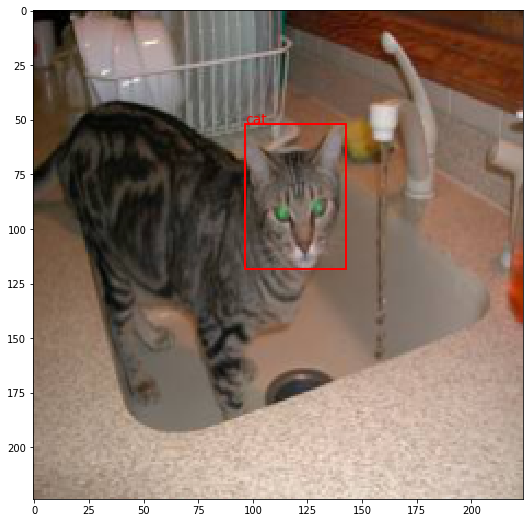

In [ ]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully           #
        # connected layer, so we could pass the features of the convolutional       #
        # network and not only the classification layer which carries significantly #
        # less information.                                                         #
        # Afterwards, create a new sequential model which includes the resnet and   #
        # add a new fully connected layer that outputs a vector with the size of    #
        # the wanted dimensionality.                                                #
        # This function has no return value.                                        #
        #############################################################################
        self.num_features = resnet18.fc.in_features
        self.resBase = torch.nn.Sequential(*(list(resnet18.children())[:-1]))

        # Classification Head
        self.c_fc1 = nn.Linear(self.num_features, 512)
        self.c_bn1 = nn.BatchNorm1d(512)
        self.c_fc2 = nn.Linear(512, 128)
        self.c_bn2 = nn.BatchNorm1d(128)
        self.c_fc3 = nn.Linear(128, 128)
        self.c_bn3 = nn.BatchNorm1d(128)
        self.c_fc4 = nn.Linear(128, 2)
        
        # Localization Head
        self.l_fc1 = nn.Linear(self.num_features, 512)
        self.l_bn1 = nn.BatchNorm1d(512)
        self.l_fc2 = nn.Linear(512, 256)
        self.l_bn2 = nn.BatchNorm1d(256)
        self.l_fc3 = nn.Linear(256, 128)
        self.l_bn3 = nn.BatchNorm1d(128)
        self.l_fc4 = nn.Linear(128, 4)

        self.drop_half = nn.Dropout(p=0.5)
        self.drop_quart = nn.Dropout(p=0.25)
        self.drop_tenth = nn.Dropout(p=0.1)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # pre-defined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box.             #
        #############################################################################
        with torch.no_grad():
          x = self.resBase(images)
        x = x.view(x.shape[0],self.num_features)
        pred = self.drop_half(self.c_bn1(nn.functional.relu(self.c_fc1(x))))
        pred = self.drop_quart(self.c_bn2(nn.functional.relu(self.c_fc2(pred))))
        pred = self.drop_tenth(self.c_bn3(nn.functional.relu(self.c_fc3(pred))))
        pred = self.drop_tenth(self.c_fc4(pred))

        bbox = self.drop_half(self.l_bn1(nn.functional.relu(self.l_fc1(x))))
        bbox = self.drop_quart(self.l_bn2(nn.functional.relu(self.l_fc2(bbox))))
        bbox = self.drop_tenth(self.l_bn3(nn.functional.relu(self.l_fc3(bbox))))
        bbox = self.drop_tenth(self.l_fc4(bbox))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        return pred, bbox

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using tensorboard or matplotlib). I have included an implementation of the IoU metric in the notebook.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model. Once you chose your model. Explain why you chose that architecture and why you think it performs better than other networks you tried - use citation from sources you used.
4. You are encouraged to try Google Colab or a free AWS / Google Cloud Platform / Azure available for students. If you have an CUDA capable GPU at home - you are welcome to use it. Training one of our networks on a Core i7 for 10 epochs took 5 minutes and reached 99% classification accuracy and over 0.75 IoU score on the validation set (this took less than a minute using a RTX 2080 Ti GPU).
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~30 minutes on CPU and ~5 minutes on GPU).
7. **In order to get full marks for this section, reach at least 98% classification accuracy and a IOU score of at least 0.70 on the validation set using a single model, explain the results and include visualizations**.
8. You are given a general skeleton for the training function. Feel free to use any different structure.

My Answer:
My model uses the features extracted in the last fully connected layer of resnet 18 (as instructed). These are then fed into two networks:
* Classification head:

Tasked with correctly classifying the pictures, the easier task of the two as resnet is already very good at that. Therefore I used a less affluent model with smaller layer sizes, as to speed up the learning.
* Localization head:

Tasked with boxing the identified object by measure of IOU against the ground truth. This model is somewhat richer, with more parameters. 

Both heads use fully connected layers with batch normalizations to stabilize the learning proccess. Adding convolutional networks upon the features extracted in the resnet wouldn't make sense as the data has lost it's visual structure/context. However I tested dropouts on the fully connected layers and found using significant dropout in early layers and decreasing its p-value later on worked best.

Bibiliography:
* https://bdtechtalks.com/2021/06/21/object-detection-deep-learning/
* https://towardsdatascience.com/object-localization-using-pre-trained-cnn-models-such-as-mobilenet-resnet-xception-f8a5f6a0228d

youtube:
* https://www.youtube.com/watch?v=K0lWSB2QoIQ&t=274s

In [ ]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    t_loss_hist = []
    t_iou_hist = []
    t_acc_hist = []

    v_loss_hist = []
    v_iou_hist = []
    v_acc_hist = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                images, labels, bboxes = sample['image'],sample['label'],sample['bbox']
                images = images.to(device)
                labels = labels.to(device)
                bboxes = bboxes.to(device)

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                  out_labels, pred_bboxes = model(images.data)
                  _, pred_labels = torch.max(out_labels, 1)
                  
                  loss = criterion_cls(out_labels, labels).float() + criterion_bbox(pred_bboxes, bboxes).float()
                  for i in range(len(pred_bboxes)):
                    iou += bb_intersection_over_union(pred_bboxes[i], bboxes[i])

                  # Backward + optimize only if in training phase
                  if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                # Statistics
                running_loss += loss * labels.size(0)
                running_corrects += torch.sum(pred_labels == labels.data)
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            if phase == 'train':
              t_loss_hist.append(epoch_loss)
              t_acc_hist.append(epoch_acc)
              t_iou_hist.append(iou)
            if phase == 'val':
              v_loss_hist.append(epoch_loss)
              v_acc_hist.append(epoch_acc)
              v_iou_hist.append(iou)

            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, t_loss_hist, t_acc_hist, t_iou_hist, v_loss_hist, v_acc_hist, v_iou_hist

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [ ]:
cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [ ]:
epochs = 32
best_model, t_loss_history, t_acc_history, t_iou_history, v_loss_history, v_acc_history, v_iou_history = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=epochs)

Epoch 0/31
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8009  |  Acc: 0.9135  |  IOU: 0.1497
val Loss: 0.2653  |  Acc: 0.9873  |  IOU: 0.3050
Epoch 1/31
----------
train Loss: 0.4322  |  Acc: 0.9670  |  IOU: 0.2211
val Loss: 0.2903  |  Acc: 0.9873  |  IOU: 0.2562
Epoch 2/31
----------
train Loss: 0.3153  |  Acc: 0.9717  |  IOU: 0.2839
val Loss: 0.1793  |  Acc: 0.9937  |  IOU: 0.3613
Epoch 3/31
----------
train Loss: 0.2198  |  Acc: 0.9969  |  IOU: 0.3448
val Loss: 0.1299  |  Acc: 0.9937  |  IOU: 0.4522
Epoch 4/31
----------
train Loss: 0.2361  |  Acc: 0.9701  |  IOU: 0.4018
val Loss: 0.1111  |  Acc: 0.9873  |  IOU: 0.5234
Epoch 5/31
----------
train Loss: 0.1519  |  Acc: 0.9858  |  IOU: 0.4739
val Loss: 0.0852  |  Acc: 0.9873  |  IOU: 0.6137
Epoch 6/31
----------
train Loss: 0.1449  |  Acc: 0.9843  |  IOU: 0.5148
val Loss: 0.0907  |  Acc: 0.9873  |  IOU: 0.6388
Epoch 7/31
----------
train Loss: 0.1110  |  Acc: 0.9921  |  IOU: 0.5448
val Loss: 0.0628  |  Acc: 0.9937  |  IOU: 0.6850
Epoch 8/31
----------
train Loss: 0.1072  |  A

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<Figure size 432x288 with 0 Axes>

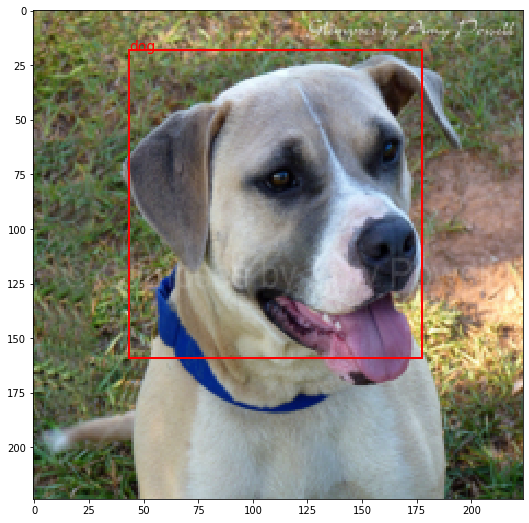

In [ ]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

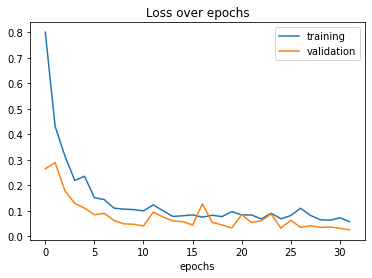

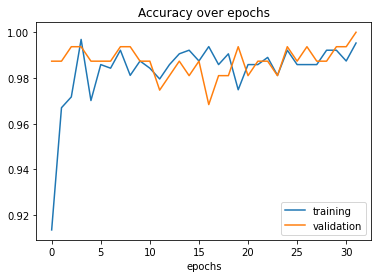

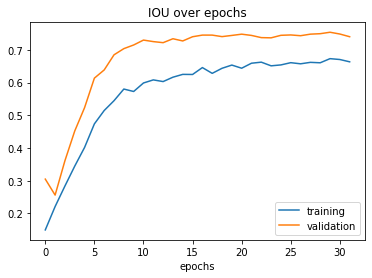

In [ ]:
plt.plot(range(epochs), t_loss_history, label='training')
plt.plot(range(epochs), v_loss_history, label='validation')
plt.xlabel('epochs')
plt.title('Loss over epochs')
plt.legend()
plt.show()

plt.plot(range(epochs), t_acc_history, label='training')
plt.plot(range(epochs), v_acc_history, label='validation')
plt.xlabel('epochs')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

plt.plot(range(epochs), t_iou_history, label='training')
plt.plot(range(epochs), v_iou_history, label='validation')
plt.xlabel('epochs')
plt.title('IOU over epochs')
plt.legend()
plt.show()


# Generating text using RNNs (40 points)

Using PyTorch, create a network that is capable of generating text, similar to the text it has seen during training. In order to tackle this problem, first read the [following blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy for some creative uses of this network and his implementation of a [char-based RNN in pure numpy](https://gist.github.com/karpathy/d4dee566867f8291f086).

While implementing your own network (**in PyTorch**), make sure to consider the following:

1. We need to get a large enough text file, with proper encoding. You should use the creations of [Shakespere](https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt).
2. Encode the text and map each character to an integer. One-hot encoding might also be a good idea.
3. You might be temped to use a dataloader, however defining your own method to obtain training batches might be easier.
4. Define your model. The following guide will help you understand how to use RNNs in PyTorch: [RNN text classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). You model should be relatively simple.
5. Train your model. Training a proper model might take a while, so you are encouraged to use [Colab](https://colab.research.google.com/).
6. Create function that takes the learned network and predicts a single character. This function should take a hidden state and an input character, and output the next hidden state and the predicted character.
7. Finally, create a sampling function that takes the network, the required length of text to generate and an initial input and generate some text.

In [4]:
# Get the usable english characters and how many are there. 
all_chars = string.printable
num_chars = len(all_chars)

# I downloaded the file and did some cleanup locally (removing anything shakespeare didn't write and any excessive spaces) before reuploading to drive.
file = open('/content/drive/MyDrive/Shakespeare/ShakesNew.txt', 'r').read()

In [5]:
# A RNN using long short-term memory layers fed into a fully connected layer.
class RNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.embed = nn.Embedding(input_size, hidden_size)
    self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden, cell):
    out = self.embed(x)
    out, (hidden, cell) = self.lstm(out.unsqueeze(1), (hidden, cell))
    out = self.fc(out.reshape(out.shape[0], -1))
    return out, (hidden, cell)

  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    return hidden, cell

In [8]:
# A wraper class that samples data, trains a RNN and uses it to generate text.
class Text_Generator():

    def __init__(self, phrase_len=250, num_iters=30000, batch_size=1, verbose=100, hidden_size=200, num_layers=2, rate=0.0003):
      self.phrase_len = phrase_len    # Length of phrases read from data in each 'sample'
      self.num_iters = num_iters      # Number of iterations performed in learning
      self.batch_size = batch_size    # Number of phrases per iteration
      self.verbose = verbose          # Print training information every 'verbose' iteration
      self.hidden_size = hidden_size  # Number of features in the hidden state of the RNN
      self.num_layers = num_layers    # Number of recurrent layers
      self.rate = rate                # Learning rate

    # Creates a new tensor from string, where every i'th element holds the all_chars index of the i'th char in string 
    def string_to_char_tensor(self, string):
      tensor = torch.zeros(len(string)).long()
      for char in range(len(string)):
        tensor[char] = all_chars.index(string[char])
      return tensor

    # Samples a phrase with length phrase_len from the data and returns an (input, labels) tuple
    def get_batch(self):
      i = random.randint(0, len(file) - self.phrase_len)
      j = i + self.phrase_len + 1
      curr_string = file[i:j]
      input = torch.zeros(self.batch_size, self.phrase_len)
      labels = torch.zeros(self.batch_size, self.phrase_len)

      for char in range(self.batch_size):
        input[char,:] = self.string_to_char_tensor(curr_string[:-1])
        labels[char,:] = self.string_to_char_tensor(curr_string[1:])

      return input.long(), labels.long()

    # Creates and trains a RNN
    def train(self):
      self.rnn = RNN(num_chars, self.hidden_size, self.num_layers, num_chars).to(device)
      optimizer = torch.optim.Adam(self.rnn.parameters(), lr=self.rate)
      criterion = nn.CrossEntropyLoss()

      for iter in range(self.num_iters):
        input, labels = self.get_batch()
        input = input.to(device)
        labels = labels.to(device)
        hidden, cell = self.rnn.init_hidden(batch_size=self.batch_size)

        self.rnn.zero_grad()
        loss = 0
        for char in range(self.phrase_len):
          output, (hidden, cell) = self.rnn(input[:, char], hidden, cell)
          loss += criterion(output, labels[:, char])

        loss.backward()
        optimizer.step()
        loss = loss.item() / self.phrase_len
        if iter % self.verbose == 0:
            print(f'Iteration {iter} out of {self.num_iters}, Loss: {loss}')

    # Generates a text with out_len letters such that it starts with a given prefix
    def generate(self, prefix = 'T', out_len=100, temperature=0.7):
      hidden, cell = self.rnn.init_hidden(batch_size=self.batch_size)
      initial_input = self.string_to_char_tensor(prefix)
      output_text = prefix

      for p in range(len(prefix) - 1):
        _, (hidden, cell) = self.rnn(initial_input[p].view(1).to(device), hidden, cell)

      last_char = initial_input[-1]  

      for p in range(out_len):
        output, (hidden, cell) = self.rnn(last_char.view(1).to(device), hidden, cell)
        output_dist = output.data.view(-1).div(temperature).exp()
        best_char = torch.multinomial(output_dist, 1)[0]    # Sample the next letter out of the output distribution
        pred_char = all_chars[best_char]
        output_text += pred_char
        last_char = self.string_to_char_tensor(pred_char)

      return output_text

In [9]:
%%time
shakesbot = Text_Generator()
shakesbot.train()

Iteration 0 out of 30000, Loss: 4.58585400390625
Iteration 100 out of 30000, Loss: 2.995195556640625
Iteration 200 out of 30000, Loss: 2.7622470703125
Iteration 300 out of 30000, Loss: 2.757346435546875
Iteration 400 out of 30000, Loss: 2.38619677734375
Iteration 500 out of 30000, Loss: 3.27090771484375
Iteration 600 out of 30000, Loss: 2.375870849609375
Iteration 700 out of 30000, Loss: 2.1308359375
Iteration 800 out of 30000, Loss: 2.2075966796875
Iteration 900 out of 30000, Loss: 2.17029736328125
Iteration 1000 out of 30000, Loss: 2.142271728515625
Iteration 1100 out of 30000, Loss: 2.074813720703125
Iteration 1200 out of 30000, Loss: 2.257420654296875
Iteration 1300 out of 30000, Loss: 2.00880859375
Iteration 1400 out of 30000, Loss: 2.088931396484375
Iteration 1500 out of 30000, Loss: 1.713722412109375
Iteration 1600 out of 30000, Loss: 1.695531982421875
Iteration 1700 out of 30000, Loss: 2.34719970703125
Iteration 1800 out of 30000, Loss: 1.4602462158203124
Iteration 1900 out of 

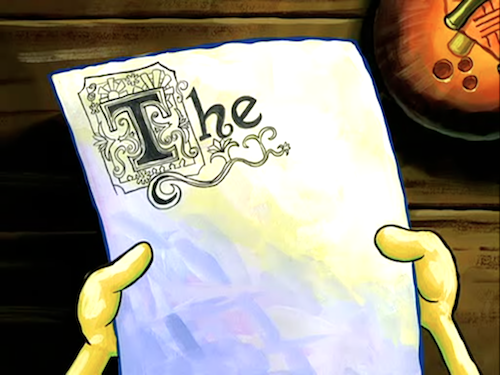

In [10]:
print(shakesbot.generate(prefix = 'The ', out_len=6000, temperature=0.85))

The did for your justice
    And that we will be to holdy summe.
    How no strange Antoth, my sides my lord.
  HOSTESS. Ay, she will to th' houldart and most may be leaves in our
    lord by shame on his dustoms and may creature to my weeting.
  MENENIUS. And Bang's an through to my free
    And good fantworrows say sure thee a man
    Shall te thee to the man. The Duke her fair and so
    wendle good long, and this kingdar may to the miston hour withal;
    But not be finger!
  COSTARD. Shall I proyantion of Pobbin Actor Mergun.
  PETRUCHIO. I learn th' pulk is what may mine flight!
       [To LORENZO

  MIRANDA. Into you heartly time! Fie, two doth they leep your
    less and hath away'd consedious stand crown that had to be oit.
    More my sorry of my issuizen, let nor heaven
    See your least to ye of mething, and and doth to be like
    here great with the fulter'd us not, I will leave opes,
    Their horser throughfore notrigurate's too discondon my
    speak him to the weathe

The End.